In [ ]:
import pickle

import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
from shapely.geometry import Point
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from constants import (
    BEST_MODEL_PATH,
    COMMUNITY_PARTITIONS_FPATH,
    FINAL_GRAPH_PATH,
    FINAL_GRAPH_PATH_WITH_INFERENCE,
)

In [ ]:
with open(FINAL_GRAPH_PATH, "rb") as f:
    G = pickle.load(f)
with open(COMMUNITY_PARTITIONS_FPATH, "rb") as f:
    partition = pickle.load(f)

count = len(set(partition.values()))
partition = None
COMM_COLS = [f"comm_{i}" for i in range(count)]

FEATURE_COLS = (
    ["street_count", "population", "distance_to_nearest_stop"]
    + COMM_COLS
    + ["is_transit_stop"]
)

In [3]:
node_features = []
labels = []
node_id_map = {}
for idx, node in enumerate(G.nodes()):
    node_id_map[node] = idx
    attr = G.nodes[node]

    features = []

    for col in FEATURE_COLS:
        if col == "is_transit_stop":
            features.append(int(attr[col]))
        else:
            features.append(float(attr[col]))

    node_features.append(features)
    label = attr["label"]
    if label is None or (isinstance(label, float) and np.isnan(label)):
        labels.append(-1)
    else:
        labels.append(int(label))

In [ ]:
x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)
edge_index = []

for u, v in G.edges():
    edge_index.append([node_id_map[u], node_id_map[v]])
    edge_index.append([node_id_map[v], node_id_map[u]])

# Convert to torch.LongTensor and transpose to shape [2, num_edges]
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Get indices of labeled nodes
labeled_idx = (y >= 0).nonzero(as_tuple=True)[0].numpy()
print(f"Total labeled nodes: {len(labeled_idx)}")

# Below was a suggestion But we will not proceed with this. Because In this way we can't determine the fitting behavior of our model. either it is overfit/underfit or balanced model.
# Split: 70% train, 20% val, 10% test
# TODO: train the model on the nodes who have a label
# If the label is 'NaN', use it for testing.


train_idx, temp_idx = train_test_split(labeled_idx, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=1 / 3, random_state=42
)  # 0.1/0.3 = 1/3

Total labeled nodes: 50435


In [5]:
from torch_geometric.data import Data
from torch_geometric.transforms import NormalizeFeatures

data = Data(x=x, edge_index=edge_index, y=y)

# Masks
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
unknown_mask = y < 0

train_mask[train_idx] = True
val_mask[val_idx] = True
test_mask[test_idx] = True

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask
data.unknown_mask = unknown_mask

# Normalize
data = NormalizeFeatures()(data)

/home/muhammadrehman/Documents/SNA/Lahore_Metro_Route/graph-ml/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2-Layered GCN with one linear Layer

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class TransitGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels=64):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.classifier = nn.Linear(hidden_channels, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return self.classifier(x)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransitGCN(in_channels=data.num_features).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

In [8]:
best_val_f1 = 0
best_model_state = None

for epoch in range(1, 301):
    # === Training ===
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # === Validation ===
    model.eval()
    with torch.no_grad():
        val_logits = model(data.x, data.edge_index)  # recompute in eval mode
        val_preds = val_logits[data.val_mask].argmax(dim=1)
        val_labels = data.y[data.val_mask]
        val_f1 = f1_score(val_labels.cpu(), val_preds.cpu())

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict()

    if epoch % 30 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val F1: {val_f1:.4f}")

Epoch 030 | Loss: 0.6374 | Val F1: 0.4108
Epoch 060 | Loss: 0.4905 | Val F1: 0.8019
Epoch 090 | Loss: 0.2854 | Val F1: 0.9350
Epoch 120 | Loss: 0.1521 | Val F1: 0.9763
Epoch 150 | Loss: 0.0875 | Val F1: 0.9892
Epoch 180 | Loss: 0.0569 | Val F1: 0.9940
Epoch 210 | Loss: 0.0411 | Val F1: 0.9960
Epoch 240 | Loss: 0.0323 | Val F1: 0.9974
Epoch 270 | Loss: 0.0265 | Val F1: 0.9976
Epoch 300 | Loss: 0.0222 | Val F1: 0.9982


In [16]:
model.load_state_dict(best_model_state)
model.eval()
with torch.no_grad():
    test_logits = model(data.x, data.edge_index)[data.test_mask]
    test_preds = test_logits.argmax(dim=1)
    test_labels = data.y[data.test_mask]

    acc = accuracy_score(test_labels.cpu(), test_preds.cpu())
    f1 = f1_score(test_labels.cpu(), test_preds.cpu())
    print(f"Test Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

Test Accuracy: 0.9976, F1 Score: 0.9975


In [17]:
with torch.no_grad():
    logits = model(data.x, data.edge_index)
    probs = F.softmax(logits, dim=1)
    preds = probs.argmax(dim=1)

uncertain_nodes = data.unknown_mask.nonzero(as_tuple=True)[0]
predicted_labels = preds[uncertain_nodes]
served_prob = probs[uncertain_nodes, 1]

In [18]:
inv_map = {v: k for k, v in node_id_map.items()}

results = {}
for idx, pred, prob in zip(
    uncertain_nodes.cpu().numpy(),
    predicted_labels.cpu().numpy(),
    served_prob.cpu().numpy(),
):
    results[inv_map[idx]] = {
        "predicted_label": int(pred),
        "served_probability": float(prob),
    }

In [ ]:
for node, res in results.items():
    G.nodes[node]["label"] = res["predicted_label"]  # 0 or 1

In [ ]:
with open(FINAL_GRAPH_PATH_WITH_INFERENCE, "wb") as f:
    pickle.dump(G, f)

## Save Model Weights

In [ ]:
torch.save(best_model_state, BEST_MODEL_PATH)
print(f"Best model weights saved to {BEST_MODEL_PATH}")

Best model weights saved to best_transit_gcn.pth


In [ ]:
with open(FINAL_GRAPH_PATH_WITH_INFERENCE, "rb") as f:
    UG = pickle.load(f)

/tmp/ipykernel_4181/1105742099.py:30: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf_nodes[gdf_nodes["served_status"] == status].plot(


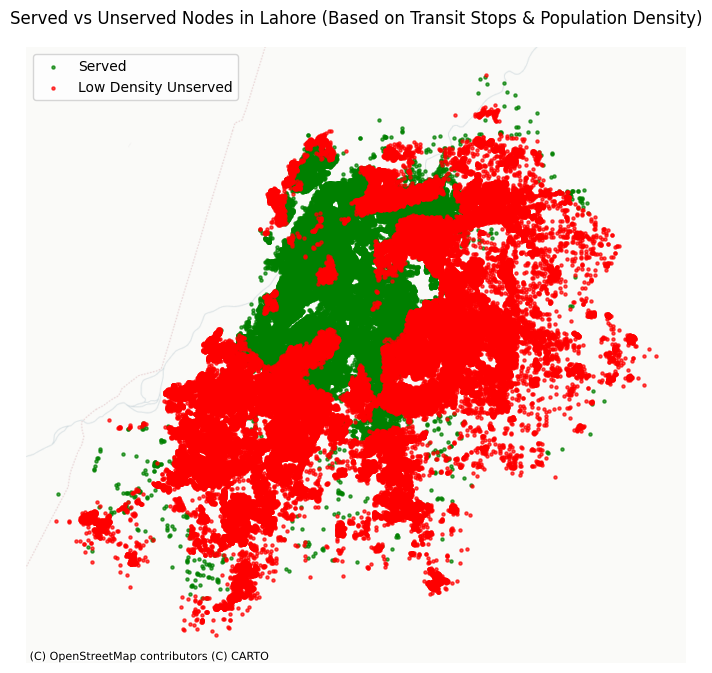

In [6]:
node_records = []

for n in UG.nodes():
    x, y = UG.nodes[n].get("x"), UG.nodes[n].get("y")
    if x is None or y is None:
        continue
    lbl = UG.nodes[n].get("label")
    status = (
        "served" if lbl == 1 else "low_density_unserved" if lbl == 0 else "uncertain"
    )
    node_records.append(
        {
            "geometry": Point(x, y),
            "population": UG.nodes[n].get("population"),
            "distance_to_station": UG.nodes[n].get("distance_to_nearest_stop"),
            "served_status": status,
        }
    )

gdf_nodes = gpd.GeoDataFrame(node_records)

fig, ax = plt.subplots(figsize=(10, 8))
colors = {
    "served": "green",
    "uncertain": "orange",
    "low_density_unserved": "red",
}

for status, color in colors.items():
    gdf_nodes[gdf_nodes["served_status"] == status].plot(
        ax=ax,
        color=color,
        markersize=5,
        alpha=0.7,
        label=status.replace("_", " ").title(),
    )

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)  # type: ignore

ax.set_title(
    "Served vs Unserved Nodes in Lahore (Based on Transit Stops & Population Density)"
)
ax.set_axis_off()
plt.legend()
plt.show()

In [ ]:
with open(COMMUNITY_PARTITIONS_FPATH, "rb") as f:
    partition = pickle.load(f)

Skipped unlabeled nodes: 0


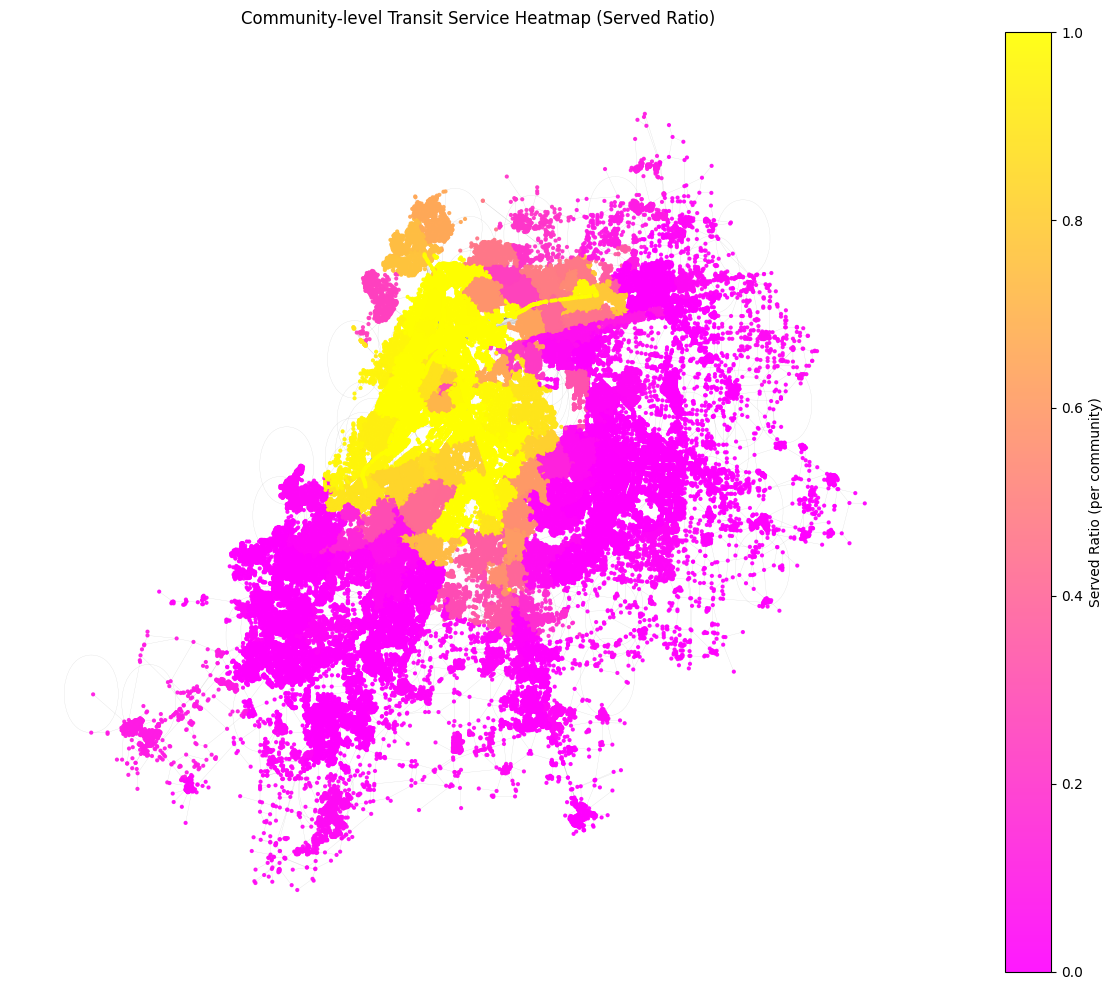

In [ ]:
labels = nx.get_node_attributes(UG, "label")

# Prepare community indexing
unique_coms = sorted(set(partition.values()))
num_comms = len(unique_coms)

com_to_idx = {c: i for i, c in enumerate(unique_coms)}

# Count labels per community
# Columns: [unserved (0), served (1)]
count_matrix = np.zeros((num_comms, 2), dtype=int)

skipped_nodes = 0

for n in UG.nodes():
    c = partition.get(n)
    lbl = labels.get(n)

    if c is None or lbl is None or np.isnan(lbl):
        skipped_nodes += 1
        continue

    lbl = int(lbl)

    if lbl not in (0, 1):
        continue

    count_matrix[com_to_idx[c], lbl] += 1

print(f"Skipped unlabeled nodes: {skipped_nodes}")

# Convert counts → ratios
row_sums = count_matrix.sum(axis=1, keepdims=True)

ratio_matrix = np.divide(
    count_matrix,
    row_sums,
    out=np.zeros_like(count_matrix, dtype=float),
    where=row_sums != 0,
)

# Compute served ratio per community
community_served_ratio = {c: ratio_matrix[com_to_idx[c], 1] for c in unique_coms}

# Assign heat value to each node
node_heat = [community_served_ratio.get(partition.get(n), 0.0) for n in UG.nodes()]

# Extract spatial positions
pos = {}

for n, data in UG.nodes(data=True):
    try:
        x = float(data.get("x"))
        y = float(data.get("y"))
        pos[n] = (x, y)
    except (TypeError, ValueError):
        continue

# Draw spatial heatmap
plt.figure(figsize=(12, 10))
plt.title(
    "Community-level Transit Service Heatmap (Served Ratio)",
    fontsize=12,
)

nodes = nx.draw_networkx_nodes(
    UG,
    pos=pos,
    node_size=4,
    node_color=node_heat,
    cmap=plt.cm.spring,
    alpha=0.9,
)

nx.draw_networkx_edges(
    UG,
    pos=pos,
    width=0.2,
    edge_color="gray",
    alpha=0.3,
)

plt.axis("off")

cbar = plt.colorbar(nodes)
cbar.set_label("Served Ratio (per community)")

plt.tight_layout()
plt.show()

Selected 3 least-served communities
Least-served subgraph: 2542 nodes, 3375 edges


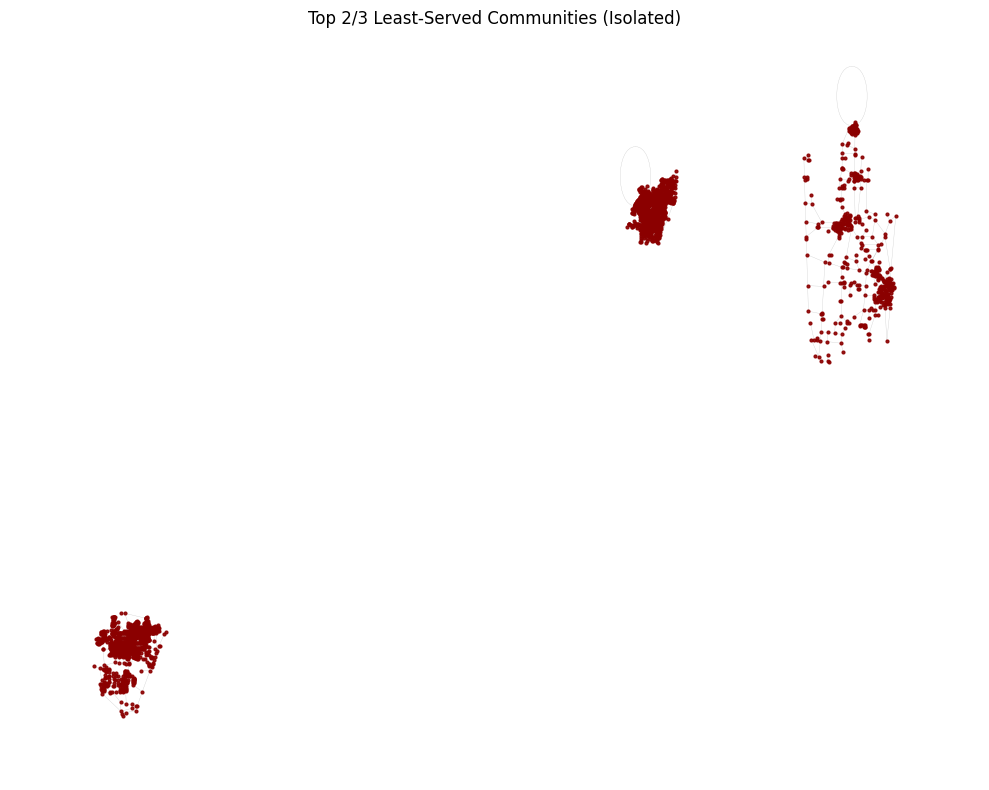

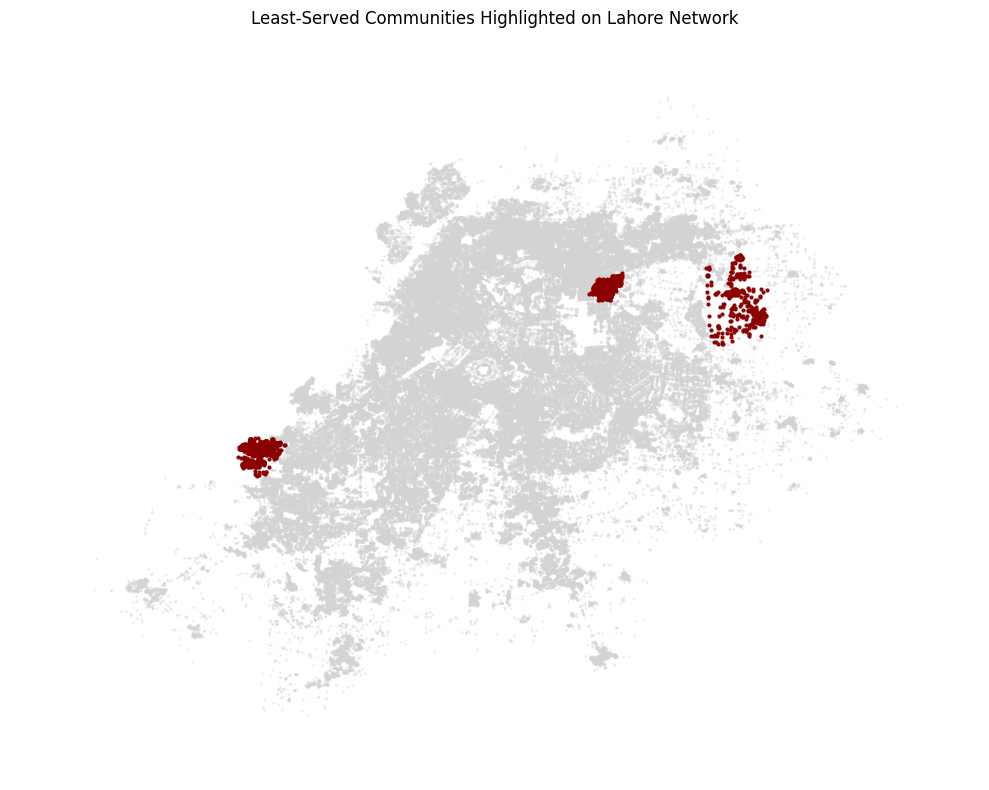

In [ ]:
labels = nx.get_node_attributes(UG, "label")

# Prepare community indexing
unique_coms = sorted(set(partition.values()))
num_comms = len(unique_coms)

com_to_idx = {c: i for i, c in enumerate(unique_coms)}

# 5. Count labels per community
count_matrix = np.zeros((num_comms, 2), dtype=int)

for n in UG.nodes():
    c = partition.get(n)
    lbl = labels.get(n)

    if c is None or lbl is None or np.isnan(lbl):
        continue

    lbl = int(lbl)
    if lbl not in (0, 1):
        continue

    count_matrix[com_to_idx[c], lbl] += 1

# Convert counts → ratios
row_sums = count_matrix.sum(axis=1, keepdims=True)

ratio_matrix = np.divide(
    count_matrix,
    row_sums,
    out=np.zeros_like(count_matrix, dtype=float),
    where=row_sums != 0,
)

# Served ratio per community
community_served_ratio = {c: ratio_matrix[com_to_idx[c], 1] for c in unique_coms}

# Select bottom 2/3 least-served communities
sorted_coms = sorted(community_served_ratio.items(), key=lambda x: x[1])

least_served_coms = {c for c, _ in sorted_coms[:3]}

print(f"Selected {len(least_served_coms)} least-served communities")

# Extract nodes & induced subgraph
least_served_nodes = [n for n in UG.nodes() if partition.get(n) in least_served_coms]

LSG = UG.subgraph(least_served_nodes).copy()

print(
    f"Least-served subgraph: "
    f"{LSG.number_of_nodes()} nodes, "
    f"{LSG.number_of_edges()} edges"
)

# Spatial positions (full + subgraph)
pos = {}
for n, data in UG.nodes(data=True):
    try:
        pos[n] = (float(data.get("x")), float(data.get("y")))
    except (TypeError, ValueError):
        continue

pos_lsg = {n: pos[n] for n in LSG.nodes() if n in pos}

# Plot isolated least-served subgraph
plt.figure(figsize=(10, 8))
plt.title("Top 2/3 Least-Served Communities (Isolated)")

nx.draw_networkx_nodes(
    LSG,
    pos=pos_lsg,
    node_size=4,
    node_color="darkred",
    alpha=0.9,
)

nx.draw_networkx_edges(
    LSG,
    pos=pos_lsg,
    width=0.25,
    edge_color="gray",
    alpha=0.4,
)

plt.axis("off")
plt.tight_layout()
plt.show()

# Overlay least-served communities on full graph
plt.figure(figsize=(10, 8))
plt.title("Least-Served Communities Highlighted on Lahore Network")

# Background graph
nx.draw_networkx_nodes(
    UG,
    pos=pos,
    node_size=1,
    node_color="lightgray",
    alpha=0.3,
)

nx.draw_networkx_edges(
    UG,
    pos=pos,
    width=0.1,
    edge_color="lightgray",
    alpha=0.2,
)

# Highlight underserved areas
nx.draw_networkx_nodes(
    LSG,
    pos=pos_lsg,
    node_size=4,
    node_color="darkred",
    alpha=0.95,
)

plt.axis("off")
plt.tight_layout()
least_served_coms = {c for c, _ in sorted_coms[:3]}
plt.show()